In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text
from mplsoccer import FontManager
from PIL import Image
import urllib
import os
import math

In [16]:
font_normal = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/roboto/'
                          'Roboto%5Bwdth,wght%5D.ttf')
font_italic = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/roboto/'
                          'Roboto-Italic%5Bwdth,wght%5D.ttf')
font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
                        'RobotoSlab%5Bwght%5D.ttf')

In [2]:
df = pd.read_csv('D:/stats project/finaldata_csv (for viz)/gk_gsaa.csv', encoding = "utf-8")

In [57]:
gradient = [
    '#cc0000',
    '#ca2000',
    '#c83200',
    '#c53f00',
    '#c14b00',
    '#bd5500',
    '#b85f00',
    '#b36800',
    '#ac7000',
    '#a57800',
    '#9e8000',
    '#968700',
    '#8d8e00',
    '#839500',
    '#789b00',
    '#6da100',
    '#5fa700',
    '#4fad00',
    '#39b300',
    '#0fb802',
]
soc_cm = mcolors.LinearSegmentedColormap.from_list('SOC', gradient, N=50)
cm.register_cmap(name='SOC', cmap=soc_cm)

In [4]:
def add_logo_on_ax(ax, team_id, bw = True):
    '''
    This function adds the logo of a football team on a specific
    axes based on the Fotmob team ID.
    Args:
        - ax (object): the matplotlib axes object.
        - team_id (int): the Fotmob team ID.
        - bw (bool): whether to add the logo as black & white or with color.
    '''
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_id:.0f}.png'))
    ax.imshow(club_icon)
    ax.axis("off")
    return ax

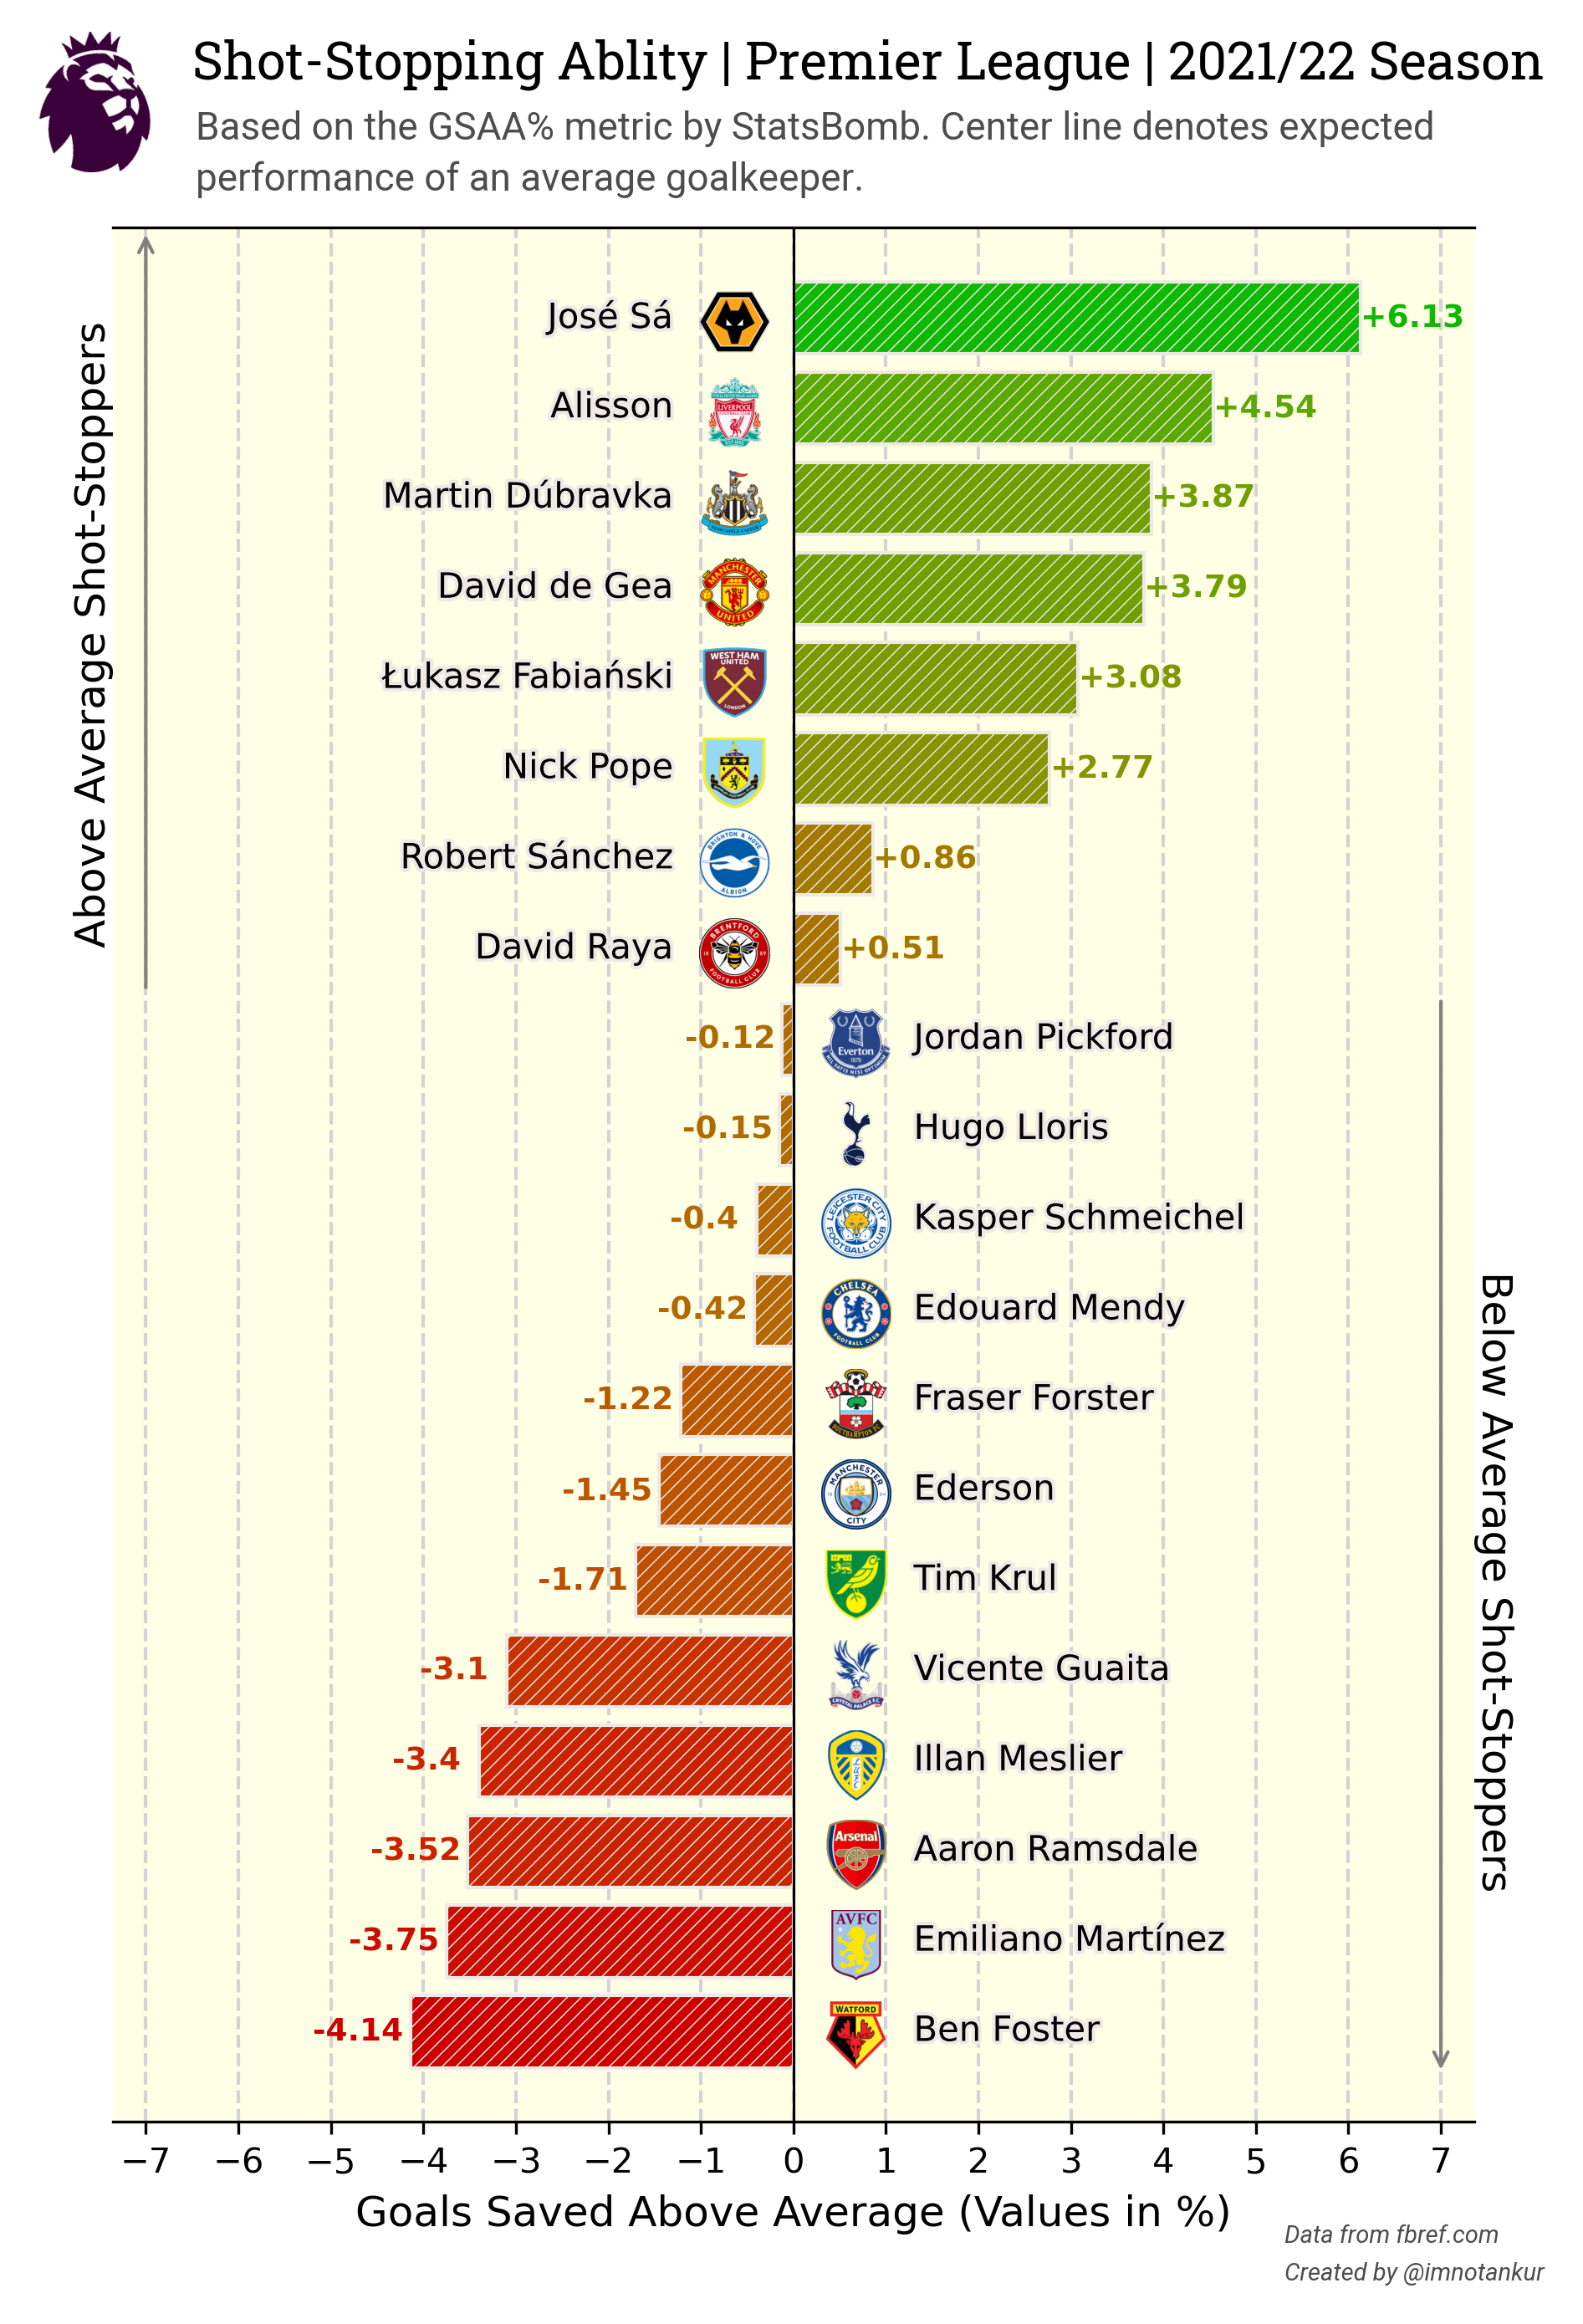

In [94]:
fig = plt.figure(figsize=(7,10), dpi=300)
ax = plt.subplot(facecolor='#ffffe6')
# -- Axes settings --------------------------------
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(ls='--', lw=1, color='lightgrey', axis='x')
ax.yaxis.set_ticks([])
# -- Hatches --------------------------------------
plt.rcParams['hatch.linewidth'] = 0.35
# -- Axes limits and tick positions ---------------
# Ensure symmetrical limits on the x-axis
max_ = max(abs(df['GSAA%'].min()), df['GSAA%'].max())
# Add 10% margin of the limit to the x-axis
max_ = max_*(1.2)
ax.set_xlim(-max_, max_)
ax.set_ylim(-1, df.shape[0])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xlabel('Goals Saved Above Average (Values in %)', size=12)
# -- Bar Chart -------------------------------------
# Declare CMAP & Normalization
norm = mcolors.Normalize(vmin=df['GSAA%'].min(),vmax=df['GSAA%'].max())
cmap = plt.get_cmap('SOC')
ax.barh(
    df.index, df['GSAA%'],
    hatch='//////', ec='#efe9e6',
    color = cmap(norm(df['GSAA%'])),
    zorder=3
)
ax.plot(
    [0,0],
    [ax.get_ylim()[0], ax.get_ylim()[1]],
    color='black',
    lw=.75,
    zorder=3
)
# -- Annotations -----------------------------------
# -- Transforms for the placement of the logo ax ---
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
for index, x in enumerate(df['GSAA%']):
    if x < 0:
        sign_offset = -1
        offset_logo = .25
        sign_text = ''
        name_align = 'left'
    else:
        sign_offset = 1
        offset_logo = .85
        sign_text = '+'
        name_align = 'right'
    player = df['Player'].iloc[index]
    text_ = ax.annotate(
        xy=(x, index),
        xytext=(sign_offset*15,0),
        text=f'{sign_text}{x}',
        color= cmap(norm(x)),
        size=9,
        weight='bold',
        ha='center',
        va='center',
        textcoords='offset points'
    )
    text_ = ax.annotate(
        xy=(sign_offset*(-1.3), index),
        xytext=(0,0),
        text=player,
        color='black',
        size=10,
        weight='normal',
        ha=name_align,
        va='center',
        textcoords='offset points')
    text_.set_path_effects([
        path_effects.Stroke(
            linewidth=2, 
            foreground='#efe9e6'
        ), 
        path_effects.Normal()
    ])
    # -- Add the logo
    team_id = df['team_id'].iloc[index]
    ax_coords = DC_to_NFC([sign_offset*(-1.2)*offset_logo, index - 0.6])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.04, 0.04], anchor = "C")
    add_logo_on_ax(logo_ax, team_id, True)

# -- Figure title and arrows --------------------------------
position_negative = df[df['GSAA%'] < 0].index.max()
position_x_negative = math.floor(-max_*(.85))
position_x_positive = math.ceil(max_*(.85))
ax.annotate(
    xy=(position_x_negative,position_negative + .5),
    xytext=(position_x_negative,ax.get_ylim()[1]),
    text='',
    arrowprops=dict(arrowstyle='<-',color='gray')
)
ax.annotate(
    xy=(position_x_positive,position_negative + .5),
    xytext=(position_x_positive,ax.get_ylim()[0] + .5),
    text='',
    arrowprops=dict(arrowstyle='<-',color='gray')
)
mid_point_positive = (position_negative + ax.get_ylim()[1])/2
mid_point_negative = (position_negative + ax.get_ylim()[0])/2
ax.annotate(
    xy=(position_x_negative,mid_point_positive),
    text='Above Average Shot-Stoppers',
    rotation=90,
    xytext=(-15,0),
    textcoords='offset points',
    ha='center',
    va='center',
    size=12
)
ax.annotate(
    xy=(position_x_positive,mid_point_negative),
    text='Below Average Shot-Stoppers',
    rotation=-90,
    xytext=(15,0),
    textcoords='offset points',
    ha='center',
    va='center',
    size=12
)

fig_text(
    x = 0.555, y = .935, 
    s = 'Shot-Stopping Ablity | Premier League | 2021/22 Season',
    va = 'bottom', ha = 'center',
    fontsize = 15, color = 'black', fontproperties = font_bold.prop
)

fig_text(
    x = 0.525, y = 0.892, 
    s = 'Based on the GSAA% metric by StatsBomb. Center line denotes expected\nperformance of an average goalkeeper.',
    va = 'bottom', ha = 'center',
    fontsize = 11, color = '#4d4d4d', fontproperties = font_normal.prop
)

fig_text(
    x = 0.94, y = 0.06,
    s = 'Data from fbref.com\nCreated by @imnotankur',
    va = "bottom", ha = 'right',
    fontsize = 7, color = "#4d4d4d", fontproperties = font_italic.prop
)

fotmob_url = 'https://images.fotmob.com/image_resources/logo/leaguelogo/'
logo_ax = fig.add_axes(
    [0.075, .89, .08, .08])
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{47}.png'))
logo_ax.imshow(club_icon)
logo_ax.axis('off')

plt.savefig(
	"D:/stats project/visualizations/gsaa_barchart.png",
	dpi = 600,
    facecolor = "#ffffff",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)
